In [1]:
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import models.loadImg as loadImg
import models.modelsCNN as modelsCNN
import models.optimizer as optimizer

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
from skimage import io


In [2]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "0,1,3" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,3" 

In [3]:
radius=48
datadir='/media/xinyi/dcis2idc/data'
sampleList=[]
for s in os.listdir('/media/xinyi/dcis2idc/data'):
    if 'hoechst'  in s and ('_1_' in s or '_3_' in s or '_4_' in s or '_6_' in s):
#     if 'hoechst'  in s and ('_3_' in s or '_4_' in s or '_6_' in s):
        sampleList.append(s)
print(sampleList)
trainingCores={'br1003a':[],'br8018a':[],'br301':[]}
for s in range(1,11):
# for s in range(5,11):
    trainingCores['br1003a'].append('A'+str(s))
    trainingCores['br1003a'].append('C'+str(s))
    trainingCores['br1003a'].append('I'+str(s))
for s in range(1,11):
    if s<9:
        trainingCores['br8018a'].append('H'+str(s))
    trainingCores['br8018a'].append('A'+str(s))
    trainingCores['br8018a'].append('B'+str(s))
    trainingCores['br8018a'].append('F'+str(s))
for s in range(1,7):
    for sr in ['A','B','C','D','E']:
        trainingCores['br301'].append(sr+str(s))

['br1003a_1_cytokeratin_555_aSMA_647_hoechst', 'br1003a_3_collagen1_647_hoechst', 'br1003a_4_cytokeratin_555_gh2ax_647_hoechst', 'br301_4_cytokeratin_555_aSMA_647_hoechst', 'br301_6_collagen1_647_hoechst', 'br8018a_1_cytokeratin_555_aSMA_647_hoechst', 'br8018a_3_collagen1_647_hoechst', 'br8018a_4_cytokeratin_555_gh2ax_647_hoechst']


In [4]:
trainingCores

{'br1003a': ['A1',
  'C1',
  'I1',
  'A2',
  'C2',
  'I2',
  'A3',
  'C3',
  'I3',
  'A4',
  'C4',
  'I4',
  'A5',
  'C5',
  'I5',
  'A6',
  'C6',
  'I6',
  'A7',
  'C7',
  'I7',
  'A8',
  'C8',
  'I8',
  'A9',
  'C9',
  'I9',
  'A10',
  'C10',
  'I10'],
 'br8018a': ['H1',
  'A1',
  'B1',
  'F1',
  'H2',
  'A2',
  'B2',
  'F2',
  'H3',
  'A3',
  'B3',
  'F3',
  'H4',
  'A4',
  'B4',
  'F4',
  'H5',
  'A5',
  'B5',
  'F5',
  'H6',
  'A6',
  'B6',
  'F6',
  'H7',
  'A7',
  'B7',
  'F7',
  'H8',
  'A8',
  'B8',
  'F8',
  'A9',
  'B9',
  'F9',
  'A10',
  'B10',
  'F10'],
 'br301': ['A1',
  'B1',
  'C1',
  'D1',
  'E1',
  'A2',
  'B2',
  'C2',
  'D2',
  'E2',
  'A3',
  'B3',
  'C3',
  'D3',
  'E3',
  'A4',
  'B4',
  'C4',
  'D4',
  'E4',
  'A5',
  'B5',
  'C5',
  'D5',
  'E5',
  'A6',
  'B6',
  'C6',
  'D6',
  'E6']}

In [3]:
allImg=loadImg.loadImg(datadir,sampleList,trainingCores,'segmented_nucleus','zproject/dna',radius,minmax=True)

['br1003a_1_cytokeratin_555_aSMA_647_hoechst', 'br1003a_3_collagen1_647_hoechst', 'br1003a_4_cytokeratin_555_gh2ax_647_hoechst', 'br301_4_cytokeratin_555_aSMA_647_hoechst', 'br301_6_collagen1_647_hoechst', 'br8018a_1_cytokeratin_555_aSMA_647_hoechst', 'br8018a_3_collagen1_647_hoechst', 'br8018a_4_cytokeratin_555_gh2ax_647_hoechst']
br1003a_1_cytokeratin_555_aSMA_647_hoechst
A1
C1
I1
A2
C2
I2
C3
I3
A4
C4
A5
C5
A6
C6
A7
C7
I7
A8
C8
I8
A9
C9
I9
C10
I10
br1003a_3_collagen1_647_hoechst
A1
C1
I1
A2
C2
I2
A3
C3
I3
C4
A5
C5
A6
C6
A7
C7
I7
A8
C8
I8
A9
C9
I9
C10
I10
br1003a_4_cytokeratin_555_gh2ax_647_hoechst
A1
C1
I1
A2
C2
I2
A3
I3
A4
C4
A5
C5
A6
C6
A7
C7
I7
A8
C8
I8
A9
C9
I9
A10
C10
br301_4_cytokeratin_555_aSMA_647_hoechst
A1
B1
C1
D1
E1
A2
B2
C2
D2
E2
A3
B3
C3
D3
E3
A4
B4
C4
D4
E4
A5
B5
C5
D5
E5
A6
B6
C6
D6
E6
br301_6_collagen1_647_hoechst
A1
B1
C1
D1
E1
A2
B2
C2
D2
E2
A3
B3
C3
D3
E3
A4
B4
C4
D4
E4
A5
B5
C5
D5
E5
A6
B6
C6
D6
E6
br8018a_1_cytokeratin_555_aSMA_647_hoechst
H1
A1
B1
F1
H2
A2
B2
F

In [18]:
sampleList_add=['br8018a_4_cytokeratin_555_gh2ax_647_hoechst']
trainingCores_add={'br8018a':['H2','H4','H7']}

In [8]:
addImg=loadImg.loadImg(datadir,sampleList_add,trainingCores_add,'segmented_nucleus','zproject/dna',radius,minmax=True)

br8018a_4_cytokeratin_555_gh2ax_647_hoechst
H2
H4
H7


In [9]:
allImg=np.concatenate((allImg,addImg),axis=0)

In [10]:
allImg.shape

(1876734, 1, 96, 96)

In [11]:
with open(os.path.join(datadir,'processed','train_cnnvae'), 'wb') as output:
    pickle.dump(allImg, output, pickle.HIGHEST_PROTOCOL)

In [12]:
#train-test split
np.random.seed(3)
pctVal=0.05
pctTest=0.1
allIdx=np.arange(allImg.shape[0])
np.random.shuffle(allIdx)
valIdx=allIdx[:int(pctVal*allImg.shape[0])]
testIdx=allIdx[int(pctVal*allImg.shape[0]):(int(pctVal*allImg.shape[0])+int(pctTest*allImg.shape[0]))]
trainIdx=allIdx[(int(pctVal*allImg.shape[0])+int(pctTest*allImg.shape[0])):]

In [13]:
with open(os.path.join(datadir,'processed','train_cnnvae_trainIdx'), 'wb') as output:
    pickle.dump(trainIdx, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(datadir,'processed','train_cnnvae_valIdx'), 'wb') as output:
    pickle.dump(valIdx, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(datadir,'processed','train_cnnvae_testIdx'), 'wb') as output:
    pickle.dump(testIdx, output, pickle.HIGHEST_PROTOCOL)

In [4]:
datadir='/media/xinyi/dcis2idc/data'
with open(os.path.join(datadir,'processed','train_cnnvae'), 'rb') as input:
    allImg=pickle.load(input)
with open(os.path.join(datadir,'processed','train_cnnvae_trainIdx'), 'rb') as input:
    trainIdx=pickle.load(input)
with open(os.path.join(datadir,'processed','train_cnnvae_valIdx'), 'rb') as input:
    valIdx=pickle.load(input)
with open(os.path.join(datadir,'processed','train_cnnvae_testIdx'), 'rb') as input:
    testIdx=pickle.load(input)

In [5]:
#VAE settings
seed=3
epochs=10000
saveFreq=2000
lr=0.00001 #initial learning rate
lr_adv=0.001
weight_decay=0 #Weight for L2 loss on embedding matrix.

# batchsize=4
batchsize=8000
kernel_size=4
stride=2
padding=1

# fc_dim1=6000
hidden1=64 #Number of channels in hidden layer 1
hidden2=128 
hidden3=256
hidden4=256
hidden5=96
fc_dim1=96*3*3
fc_dim2=6000
# fc_dim3=128
# fc_dim4=128
# gcn_dim1=2600
# adv_hidden=128

dropout=0.01
kl_weight=0.0000001
model_str='cnn_vae'

name='exp0'
logsavepath='/media/xinyi/dcis2idc/log/cnnvae'+name
modelsavepath='/media/xinyi/dcis2idc/models/cnnvae'+name
plotsavepath='/media/xinyi/dcis2idc/plots/cnnvae'+name


if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)

In [6]:
# Set cuda and seed
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.enabled = True
    
loss_match=torch.nn.MSELoss()
# Create model
if model_str=='cnn_vae':
    modelcnn = modelsCNN.CNN_VAE(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,fc_dim2)
    loss_kl=optimizer.optimizer_kl
    loss_x=torch.nn.MSELoss()
if model_str=='cnn_vae_sharded':
    modelcnn = modelsCNN.CNN_VAE_sharded(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,fc_dim2)
    loss_kl=optimizer.optimizer_kl
    loss_x=torch.nn.MSELoss()
    use_cuda=False

if model_str=='cnn_vae_alexnet':
    modelcnn = modelsCNN.CNN_VAE_alexnet(fc_dim1)
    loss_kl=optimizer.optimizer_kl
    loss_x=torch.nn.MSELoss(reduction='sum')

    
modelcnn.cuda()       
optimizerCNN = optim.Adam(modelcnn.parameters(), lr=lr, weight_decay=weight_decay)

In [8]:
use_cuda=True
def train(epoch):
    t = time.time()
    modelcnn.train()
    
    loss_kl_train_all=0
    loss_x_train_all=0
    loss_all=0
    ntrainBatches=int(np.ceil(trainIdx.shape[0]/batchsize))
    for i in range(ntrainBatches):
#         if i%200==0:
#         print(i)
        trainIdx_i=trainIdx[i*batchsize:min((i+1)*batchsize,trainIdx.shape[0])]
        trainInput=torch.tensor(allImg[trainIdx_i])
#         print(trainInput.shape)

        if use_cuda:
            trainInput=trainInput.cuda().float()
        optimizerCNN.zero_grad()

        recon, z, mu, logvar = modelcnn(trainInput)

        loss_kl_train=loss_kl(mu, logvar)
        loss_x_train=loss_x(recon, trainInput)
        loss=loss_kl_train*kl_weight+loss_x_train
        
        
        loss_kl_train_all+=loss_kl_train.item()
        loss_x_train_all+=loss_x_train.item()
        loss_all+=loss.item()
        
        loss.backward()
        optimizerCNN.step()

    loss_kl_train_all=loss_kl_train_all/ntrainBatches
    loss_x_train_all=loss_x_train_all/ntrainBatches
    loss_all=loss_all/ntrainBatches
    
    with torch.no_grad():
        modelcnn.eval()
        loss_val_all=0
        nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
            valInput=torch.tensor(allImg[valIdx_i])
            if use_cuda:
                valInput=valInput.cuda().float()
            recon,z, mu, logvar = modelcnn(valInput)

            loss_val=loss_x(recon, valInput).item()

            loss_val_all+=loss_val

        loss_val_all=loss_val_all/nvalBatches
    
    print('Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss_all),
          'loss_kl_train: {:.4f}'.format(loss_kl_train_all),
          'loss_x_train: {:.4f}'.format(loss_x_train_all),
          'loss_val: {:.4f}'.format(loss_val_all),
          'time: {:.4f}s'.format(time.time() - t))
    return loss_all,loss_kl_train_all,loss_x_train_all,loss_val_all

    
train_loss_ep=[None]*epochs
train_loss_kl_ep=[None]*epochs
train_loss_x_ep=[None]*epochs
val_loss_ep=[None]*epochs
t_ep=time.time()

# pre_t=4
pre_t=-1
for ep in range(epochs):
# for ep in range(10000,20000):
    train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],val_loss_ep[ep]=train(ep)

        
    if ep%saveFreq == (saveFreq-1):
        torch.save(modelcnn.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))
    if use_cuda:
        modelcnn.cuda()
        torch.cuda.empty_cache()
print(' total time: {:.4f}s'.format(time.time() - t_ep))

Epoch: 0000 loss_train: 0.0370 loss_kl_train: 0.2818 loss_x_train: 0.0370 loss_val: 0.0309 time: 119.5322s
Epoch: 0001 loss_train: 0.0288 loss_kl_train: 0.3264 loss_x_train: 0.0288 loss_val: 0.0253 time: 117.0593s
Epoch: 0002 loss_train: 0.0240 loss_kl_train: 0.3912 loss_x_train: 0.0240 loss_val: 0.0218 time: 117.8319s
Epoch: 0003 loss_train: 0.0208 loss_kl_train: 0.4713 loss_x_train: 0.0208 loss_val: 0.0192 time: 118.2353s
Epoch: 0004 loss_train: 0.0185 loss_kl_train: 0.5519 loss_x_train: 0.0185 loss_val: 0.0174 time: 120.3324s
Epoch: 0005 loss_train: 0.0168 loss_kl_train: 0.6327 loss_x_train: 0.0168 loss_val: 0.0158 time: 118.7505s
Epoch: 0006 loss_train: 0.0153 loss_kl_train: 0.7147 loss_x_train: 0.0153 loss_val: 0.0145 time: 118.8495s
Epoch: 0007 loss_train: 0.0140 loss_kl_train: 0.7978 loss_x_train: 0.0140 loss_val: 0.0133 time: 119.4746s
Epoch: 0008 loss_train: 0.0127 loss_kl_train: 0.8904 loss_x_train: 0.0127 loss_val: 0.0120 time: 119.6046s
Epoch: 0009 loss_train: 0.0114 loss_k

Epoch: 0077 loss_train: 0.0008 loss_kl_train: 3.6030 loss_x_train: 0.0008 loss_val: 0.0008 time: 122.2093s
Epoch: 0078 loss_train: 0.0008 loss_kl_train: 3.6128 loss_x_train: 0.0008 loss_val: 0.0008 time: 118.5666s
Epoch: 0079 loss_train: 0.0008 loss_kl_train: 3.6223 loss_x_train: 0.0008 loss_val: 0.0008 time: 118.4376s
Epoch: 0080 loss_train: 0.0008 loss_kl_train: 3.6316 loss_x_train: 0.0008 loss_val: 0.0008 time: 118.7105s
Epoch: 0081 loss_train: 0.0008 loss_kl_train: 3.6407 loss_x_train: 0.0008 loss_val: 0.0007 time: 117.9362s
Epoch: 0082 loss_train: 0.0007 loss_kl_train: 3.6497 loss_x_train: 0.0007 loss_val: 0.0007 time: 117.8163s
Epoch: 0083 loss_train: 0.0007 loss_kl_train: 3.6585 loss_x_train: 0.0007 loss_val: 0.0007 time: 117.6674s
Epoch: 0084 loss_train: 0.0007 loss_kl_train: 3.6671 loss_x_train: 0.0007 loss_val: 0.0007 time: 117.8100s
Epoch: 0085 loss_train: 0.0007 loss_kl_train: 3.6755 loss_x_train: 0.0007 loss_val: 0.0007 time: 117.3483s
Epoch: 0086 loss_train: 0.0007 loss_k

Epoch: 0154 loss_train: 0.0005 loss_kl_train: 4.0325 loss_x_train: 0.0005 loss_val: 0.0005 time: 118.2446s
Epoch: 0155 loss_train: 0.0005 loss_kl_train: 4.0359 loss_x_train: 0.0005 loss_val: 0.0005 time: 118.8031s
Epoch: 0156 loss_train: 0.0005 loss_kl_train: 4.0394 loss_x_train: 0.0005 loss_val: 0.0005 time: 120.3099s
Epoch: 0157 loss_train: 0.0005 loss_kl_train: 4.0427 loss_x_train: 0.0005 loss_val: 0.0005 time: 118.7424s
Epoch: 0158 loss_train: 0.0005 loss_kl_train: 4.0460 loss_x_train: 0.0005 loss_val: 0.0005 time: 119.2394s
Epoch: 0159 loss_train: 0.0005 loss_kl_train: 4.0493 loss_x_train: 0.0005 loss_val: 0.0005 time: 119.0553s
Epoch: 0160 loss_train: 0.0005 loss_kl_train: 4.0526 loss_x_train: 0.0005 loss_val: 0.0005 time: 118.5512s
Epoch: 0161 loss_train: 0.0005 loss_kl_train: 4.0558 loss_x_train: 0.0005 loss_val: 0.0005 time: 118.2988s
Epoch: 0162 loss_train: 0.0005 loss_kl_train: 4.0591 loss_x_train: 0.0005 loss_val: 0.0005 time: 119.6257s
Epoch: 0163 loss_train: 0.0005 loss_k

Epoch: 0231 loss_train: 0.0004 loss_kl_train: 4.2462 loss_x_train: 0.0004 loss_val: 0.0004 time: 118.9901s
Epoch: 0232 loss_train: 0.0004 loss_kl_train: 4.2486 loss_x_train: 0.0004 loss_val: 0.0004 time: 117.7910s
Epoch: 0233 loss_train: 0.0004 loss_kl_train: 4.2509 loss_x_train: 0.0004 loss_val: 0.0004 time: 118.1420s
Epoch: 0234 loss_train: 0.0004 loss_kl_train: 4.2532 loss_x_train: 0.0004 loss_val: 0.0004 time: 116.9198s
Epoch: 0235 loss_train: 0.0004 loss_kl_train: 4.2555 loss_x_train: 0.0004 loss_val: 0.0004 time: 118.0051s
Epoch: 0236 loss_train: 0.0004 loss_kl_train: 4.2578 loss_x_train: 0.0004 loss_val: 0.0004 time: 118.0517s
Epoch: 0237 loss_train: 0.0004 loss_kl_train: 4.2601 loss_x_train: 0.0004 loss_val: 0.0004 time: 122.3402s
Epoch: 0238 loss_train: 0.0004 loss_kl_train: 4.2625 loss_x_train: 0.0004 loss_val: 0.0004 time: 118.1213s
Epoch: 0239 loss_train: 0.0004 loss_kl_train: 4.2647 loss_x_train: 0.0004 loss_val: 0.0004 time: 118.7020s
Epoch: 0240 loss_train: 0.0004 loss_k

Epoch: 0308 loss_train: 0.0004 loss_kl_train: 4.4026 loss_x_train: 0.0004 loss_val: 0.0004 time: 120.6269s
Epoch: 0309 loss_train: 0.0004 loss_kl_train: 4.4043 loss_x_train: 0.0004 loss_val: 0.0004 time: 119.0321s
Epoch: 0310 loss_train: 0.0004 loss_kl_train: 4.4061 loss_x_train: 0.0004 loss_val: 0.0004 time: 119.1297s


KeyboardInterrupt: 

In [9]:
torch.save(modelcnn.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))

In [10]:
with open(os.path.join(logsavepath,'train_loss'), 'wb') as output:
    pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_kl'), 'wb') as output:
    pickle.dump(train_loss_kl_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_x'), 'wb') as output:
    pickle.dump(train_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss'), 'wb') as output:
    pickle.dump(val_loss_ep, output, pickle.HIGHEST_PROTOCOL)


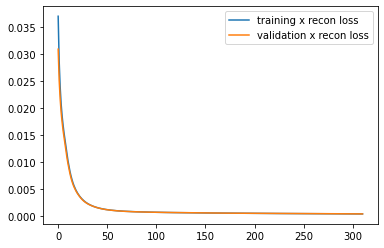

In [13]:
plt.plot(np.arange(epochs),train_loss_x_ep)
plt.plot(np.arange(epochs),val_loss_ep)
# plt.plot(np.arange(epochs),train_loss_kl_ep)
plt.legend(['training x recon loss','validation x recon loss','training kl loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3_x.jpg'))
plt.show()


In [16]:
#test loss
with torch.no_grad():
    modelcnn.cuda()
    modelcnn.eval()
    loss_test_all=0
    ntestBatches=int(np.ceil(testIdx.shape[0]/batchsize))
    for i in range(ntestBatches):
        testIdx_i=testIdx[i*batchsize:min((i+1)*batchsize,testIdx.shape[0])]
        testInput=torch.tensor(allImg[testIdx_i])
        if use_cuda:
            testInput=testInput.cuda().float()
        recon,z, mu, logvar = modelcnn(testInput)

        loss_test=loss_x(recon, testInput).item()

        loss_test_all+=loss_test

    loss_test_all=loss_test_all/ntestBatches
print(loss_test_all)

0.0003748567808846322


0


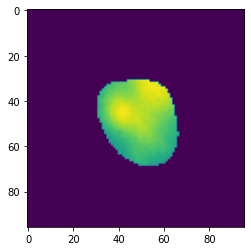

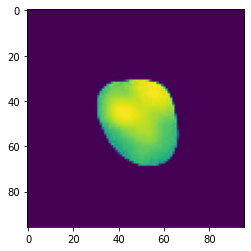

1


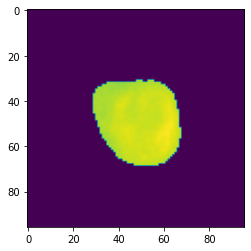

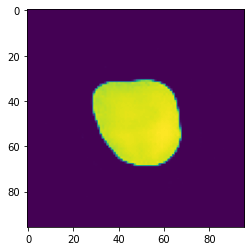

2


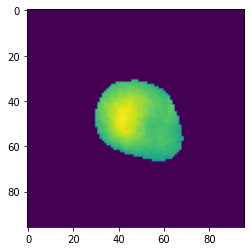

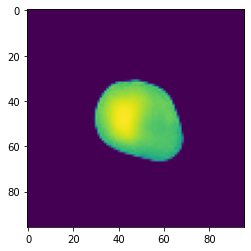

3


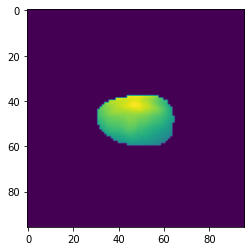

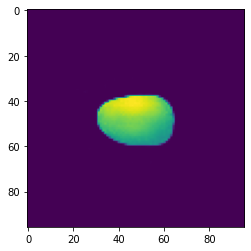

4


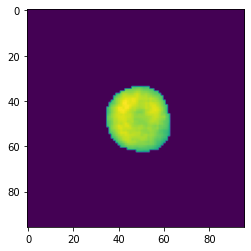

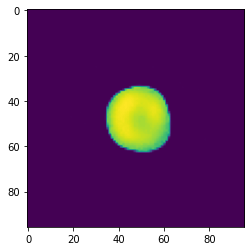

5


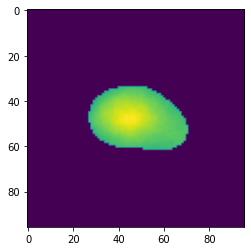

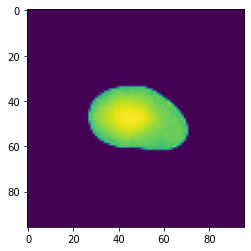

6


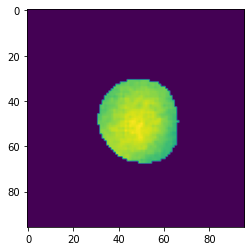

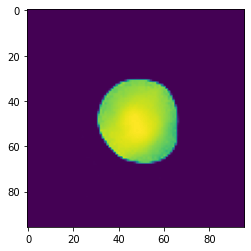

7


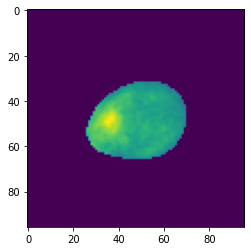

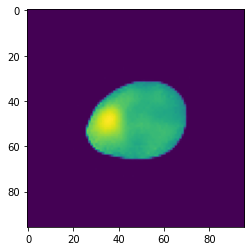

8


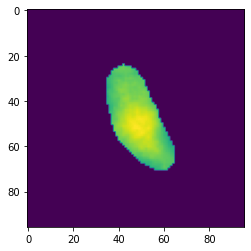

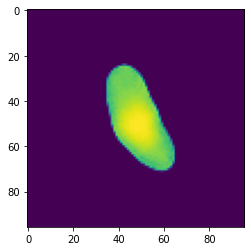

9


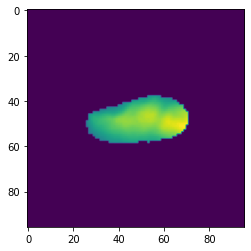

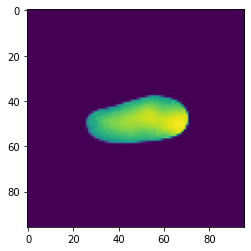

In [19]:
for i in range(10):
    print(i)
    plt.imshow(testInput[i][0].cpu().detach().numpy())
    plt.show()
    plt.imshow(recon[i][0].cpu().detach().numpy())
    plt.show()

In [46]:
#compute latent
ep=311
use_cuda=True
modelcnn.load_state_dict(torch.load(os.path.join(modelsavepath,str(ep)+'.pt')))
latent=np.zeros((allImg.shape[0],fc_dim2))
with torch.no_grad():
    modelcnn.cuda()
    modelcnn.eval()
    nplotBatches=int(np.ceil(allImg.shape[0]/batchsize))
    for i in range(nplotBatches):
        plotInput=torch.tensor(allImg[i*batchsize:min((i+1)*batchsize,allImg.shape[0])])
        if use_cuda:
            plotInput=plotInput.cuda().float()
        recon,z, mu, logvar = modelcnn(plotInput)
        latent[i*batchsize:min((i+1)*batchsize,allImg.shape[0])]=mu.cpu().detach().numpy()


In [ ]:
#get sample names
def loadOneSampleName(samplename,segmentationPath,imgPath,centroidPath,radius,minmax):
    segmentednuclei=io.imread(segmentationPath)
    pos=pd.read_csv(centroidPath)
    rep=pos.shape[0]
    for i in range(pos.shape[0]):
        if int(pos.iloc[i,2])-radius<0 or int(pos.iloc[i,2])+radius>(segmentednuclei.shape[0]) or int(pos.iloc[i,3])-radius<0 or int(pos.iloc[i,3])+radius>(segmentednuclei.shape[1]):
            rep-=1
    sampleNameList=np.repeat(samplename,rep)
    return sampleNameList
    
def loadImgName(datadir,sampleList,coreList,segmentationPath,imgPath,radius,minmax=True):
    allImg=None
    
    for s in sampleList:
        print(s)
        coreS=None
        for k in coreList.keys():
            if k in s:
                coreS=coreList[k]
                break
        for c in coreS:
            if not os.path.exists(os.path.join(datadir,s,segmentationPath,c+'.tif')) or (not os.path.exists(os.path.join(datadir,s,imgPath,c+'.tif'))) or (not os.path.exists(os.path.join(datadir,s,'spatial_positioning',c+'.csv'))):
                continue
            print(c)
            samplename=s+'_'+c
            if allImg is None:
                allImg=loadOneSampleName(samplename,os.path.join(datadir,s,segmentationPath,c+'.tif'), os.path.join(datadir,s,imgPath,c+'.tif'), os.path.join(datadir,s,'spatial_positioning',c+'.csv'), radius,minmax)
            else:
                allImg = np.concatenate((allImg, loadOneSampleName(samplename,os.path.join(datadir,s,segmentationPath,c+'.tif'), os.path.join(datadir,s,imgPath,c+'.tif'), os.path.join(datadir,s,'spatial_positioning',c+'.csv'), radius,minmax)), axis=0)
    return allImg

In [ ]:
allImgNames=loadImgName(datadir,sampleList,trainingCores,'segmented_nucleus','zproject/dna',radius,minmax=True)

In [ ]:
addImgName=loadImgName(datadir,sampleList_add,trainingCores_add,'segmented_nucleus','zproject/dna',radius,minmax=True)
allImgNames=np.concatenate((allImgNames,addImgName),axis=0)

In [ ]:
allImgNames.shape[0]==allImg.shape[0]

In [8]:
import umap

In [25]:
plottingIdx

array([9.800000e+02, 9.840000e+02, 3.280000e+02, ..., 1.851394e+06,
       1.851943e+06, 1.852003e+06])

In [10]:
#umap
# np.random.seed(3)
# plotPCT=0.1
# plottingIdx=np.array([])
# for s in np.unique(allImgNames):
#     nsamples=int(np.sum(allImgNames==s)*plotPCT)
#     plottingIdx=np.concatenate((plottingIdx,
#                                 np.random.choice(np.arange(allImgNames.shape[0])[allImgNames==s],nsamples,replace=False)))
n_neighbors=10
min_dist=0.25

# reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed).fit(latent[plottingIdx.astype(int)])
savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'epoch'+str(ep)

In [27]:
with open(os.path.join(modelsavepath,'umap'+savenameAdd), 'wb') as output:
    pickle.dump(reducer, output, pickle.HIGHEST_PROTOCOL)

In [28]:
with open(os.path.join(modelsavepath,'umap'+savenameAdd+'_plottingIdx'), 'wb') as output:
    pickle.dump(plottingIdx, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(datadir,'processed','train_cnnvae_names'), 'wb') as output:
    pickle.dump(allImgNames, output, pickle.HIGHEST_PROTOCOL)

In [11]:
with open(os.path.join(datadir,'processed','train_cnnvae_names'), 'rb') as input:
    allImgNames=pickle.load(input)
with open(os.path.join(modelsavepath,'umap'+savenameAdd+'_plottingIdx'), 'rb') as input:
    plottingIdx=pickle.load(input)

In [23]:
np.random.seed(seed)
def plotembeddingbyCT(ctlist,savename,excludelist,embedding,savepath,plotname,plotdimx=0,plotdimy=1,savenameAdd='',img=None,ncol=5):
    celltypes=np.unique(ctlist)
#     print(celltypes)
    celltypes_dict={}
    idx=0
    for ct in celltypes:
        celltypes_dict[ct]=idx
        idx+=1
        
    colortest=sns.color_palette("husl", celltypes.size)
#     colortest=sns.color_palette("husl", 9)
#     np.random.shuffle(colortest)
    fig, ax = plt.subplots(dpi=400)
    if not img is None:
        plt.imshow(img)
    for ct in celltypes:
        if ct in excludelist:
            continue
        idx=(ctlist==ct)
        if not img is None:
            ax.scatter(
                embedding[idx, plotdimy],
                embedding[idx, plotdimx],
                color=colortest[celltypes_dict[ct]],label=ct,s=1.5,alpha=0.5
    #             color=colortest[int(ct)],label=ct,s=1.5,alpha=0.5
                )
        else:
            ax.scatter(
                embedding[idx, plotdimx],
                embedding[idx, plotdimy],
                color=colortest[celltypes_dict[ct]],label=ct,s=1.5,alpha=0.5
    #             color=colortest[int(ct)],label=ct,s=1.5,alpha=0.5
                )

    plt.gca().set_aspect('equal', 'datalim')
    fig.set_figheight(5)
    fig.set_figwidth(5)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])
    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=ncol,prop={'size': 6})
#     ax.legend(ncol=3)
#     plt.title(plotname+' embedding', fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(savepath,savename+savenameAdd+'.jpg'),bbox_inches='tight')
#     plt.show()
    
#     fig.clf()
    plt.close('all')
    
    gc.collect()
    
np.random.seed(seed)
def plotembeddingbyCT_contrast(ctlist,savename,excludelist,embedding,savepath,plotname,plotdimx=0,plotdimy=1,savenameAdd='',maxplot=None): 
    celltypes=np.unique(ctlist)
    celltypes_dict={}
    idx=0
    for ct in celltypes:
        celltypes_dict[ct]=idx
        idx+=1

    colortest=sns.color_palette("tab10")
    if not os.path.exists(os.path.join(savepath)):
        os.makedirs(savepath)

    for ct in celltypes:
        if maxplot and int(ct)>maxplot:
            continue
        fig, ax = plt.subplots()
        if ct == 'Unassigned':
            continue

        idx=(ctlist!=ct)
        ax.scatter(
            embedding[idx, plotdimx],
            embedding[idx, plotdimy],
            color=colortest[1],label='others',s=1,alpha=0.5
            )

        idx=(ctlist==ct)
        ax.scatter(
            embedding[idx, plotdimx],
            embedding[idx, plotdimy],
            color=colortest[0],label=ct,s=3,alpha=0.5
            )

        plt.gca().set_aspect('equal', 'datalim')
        fig.set_figheight(10)
        fig.set_figwidth(10)
        ax.legend()
#         plt.title(plotname+' embedding', fontsize=24)
        plt.gcf().savefig(os.path.join(savepath,savename+'_'+str(ct)+savenameAdd+'.jpg'))
#         plt.show()
#         nplot+=1
        
    
#         fig.clf()
        plt.close('all')
        gc.collect()

In [13]:
plottype='umap'
sampledir=plotsavepath
savedir=os.path.join(sampledir,'embedding_'+plottype)
clustersavedir=os.path.join(sampledir,'cluster')
if not os.path.exists(sampledir):
    os.mkdir(sampledir)
if not os.path.exists(savedir):
    os.mkdir(savedir)
if not os.path.exists(clustersavedir):
    os.mkdir(clustersavedir)

In [40]:
dim1=0
dim2=1
plotembeddingbyCT(allImgNames[plottingIdx.astype(int)],'sample_umaptrain',[],reducer.embedding_,savedir,plottype+' of all samples',plotdimx=dim1,plotdimy=dim2,savenameAdd=savenameAdd+'_pc'+str(dim1)+'pc'+str(dim2),ncol=2)


/tmp/ipykernel_2765903/3669990762.py:47: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


In [14]:
#plot by disease progression
br1003aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR1003a specs.xlsx',header=10)
br301Specs=pd.read_excel('/media/xinyi/dcis2idc/data/BR301 specs.xlsx',header=10)
br8018aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR8018a specs.xlsx',header=10)
br1003aSpecs.index=br1003aSpecs.loc[:,'Position']
br301Specs.index=br301Specs.loc[:,'Position']
br8018aSpecs.index=br8018aSpecs.loc[:,'Position']

In [15]:
progList=np.copy(allImgNames)
for s in np.unique(allImgNames):
    ssplit=s.split('_')
    if 'br1003a'==ssplit[0]:
        prog_s=br1003aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br301'==ssplit[0]:
        prog_s=br301Specs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br8018a'==ssplit[0]:
        prog_s=br8018aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    progList[allImgNames==s]=prog_s

In [59]:
plotembeddingbyCT(progList[plottingIdx.astype(int)],'prog_umaptrain',[],reducer.embedding_,savedir,plottype+' of all samples',plotdimx=dim1,plotdimy=dim2,savenameAdd=savenameAdd+'_pc'+str(dim1)+'pc'+str(dim2),ncol=2)
plotembeddingbyCT_contrast(progList[plottingIdx.astype(int)],'prog_umaptrain',[],reducer.embedding_,os.path.join(savedir,'contrast'),plottype+' of all samples',plotdimx=dim1,plotdimy=dim2,savenameAdd=savenameAdd+'_pc'+str(dim1)+'pc'+str(dim2))


In [29]:
#get coord
coordlist=np.zeros((allImgNames.shape[0],2))
uniquenames,nameIdx=np.unique(allImgNames,return_index=True)
for sidx in range(uniquenames.size):
    s=uniquenames[sidx]
    startidx=nameIdx[sidx]
    posPath=os.path.join(datadir,'_'.join(s.split('_')[:-1]),'spatial_positioning',s.split('_')[-1] +'.csv')
    pos=pd.read_csv(posPath)
    
    segmentationPath=os.path.join(datadir,'_'.join(s.split('_')[:-1]),'segmented_nucleus',s.split('_')[-1] +'.tif')
    segmentednuclei=io.imread(segmentationPath)
    for i in range(pos.shape[0]):
        if int(pos.iloc[i,2])-radius<0 or int(pos.iloc[i,2])+radius>(segmentednuclei.shape[0]) or int(pos.iloc[i,3])-radius<0 or int(pos.iloc[i,3])+radius>(segmentednuclei.shape[1]):
            continue
        coordlist[startidx]=np.array((pos.iloc[i,2],pos.iloc[i,3]))
        startidx+=1

In [30]:
with open(os.path.join(datadir,'processed','train_cnnvae_coord'), 'wb') as output:
    pickle.dump(coordlist, output, pickle.HIGHEST_PROTOCOL)